# Overview of the evaluation module

The evaluation module provides a set of functionalities that can help you assess the performance of your bias correction method. Bias correction is prone to mis-use and requires careful evaluation, as demonstrated and argued in Maraun et al. 2017. In particular, the bias correction methods implemented in this package operate on a marginal level, that is they correct distribution of individual variables at individual locations. There is therefore only a subset of climate model biases that these debiasers will be able to correct. Biases in the temporal or spatial structure of climate models, or the feedbacks to large-scale weather patterns might not be well corrected. 

It is therefore important to evaluate not only marginal but also temporal, spatial and spatiotemporal properties of the bias corrected model to gain insight into which biases have been corrected, and which remain after debiasing that hint towards larger-scale issues with the climate model used.

**There are three components to the evaluation module:**
- **Testing assumptions of different debiasers**: Different debiasers rely on different assumptions - some are parametrics, others non-parametric, some bias correct each day of the year separately, others are applied to all days of the year in the same way. This components is meant to check some of these assumptions and help the user rule out the use of some debiasers that are not fit for purpose in this specific application.
- **Evaluating the bias corrected model on a validation period**: In order to assess the performance of a bias correction method, the bias corrected model data should be compared to observational / reanalysis data. This component provides insight into the correction of marginal biases, as well as temporal, spatial and spatiotemporal metrics.
- **Investigating whether the climate change trend is preserved**: Bias correction methods can significantly modify the trend projected in the climate model simulation (Switanek 2017). If the user does not consider the simulated trend to be credible, then modifying it can be a good thing to do. However, any trend modification should always be a concious and informed choice, and it the belief that a bias correction method will improve the trend should be justified. Otherwise, the trend modification through the application of a bias correction method should be considered an artifact. Therefore, this section assesses whether a certain method preserves the cliamte model trend or not. Some methods implemented in this package are explicitly trend preserving, for more details see the methodologies and descriptions of the individual debiasers.

**This notebook demonstrates the evaluation of three debiasers, ISIMIP (Lange 2021), CDFt (Vrac 2017) and Quantile Delta Mapping (Cannon et al 2015) to the variables tas (daily mean 2m surface temperature, K) and pr (total daily precipitation flux, kg/m2/s). ISIMIP is additionally applied to tasmin (daily minimum 2m surface temperature, K) and tasmax (daily maximum 2m surface temperature, K)**

## Set-up and data pre-processing

This step requires you to have downloaded and preprocessed observational or reanalysis data (such as ERA5) as well as a historical, as well as a future simulation of a climate model. Necessary pre-processing steps include regridding the datasets to the same area and grid in space and time and conducted checks for corrupted or missing data. If you don't have testing data yet, you can either work with the testing data stored in FOLDER, or use the PREPROCESS_NOTEBOOK to download new testing data.

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import numpy as np
import iris
import math

from scipy.stats import norm, laplace, gamma, beta

from PACKAGE_NAME.variables import *
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import assumptions, correlation, marginal, spatial, trend
from PACKAGE_NAME.evaluate.metrics import *

**OPEN QUESTION: put these functions somewhere**

In [3]:
from cf_units import num2date

def get_dates(x):
    
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable, split_ratio):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    if obs_all.shape != cm.shape:
        raise ValueError('Observation and climate model data do not have same dimensions.')
    
    boundary_step = math.floor(obs_all.shape[2]*split_ratio)
    
    obs = obs_all[:, :, 0:boundary_step]
    obs_validate = obs_all[:, :, boundary_step+1:]
    cm_hist = cm[:, :, 0:boundary_step]
    cm_validate = cm[:, :, boundary_step+1:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future

Initialize testing data and dates for tas and pr

In [4]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data('tas', 0.7)
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_dates_validate, pr_dates_future = preprocess_isimip_evaluation_testing_data('pr', 0.7)

**Calculating tasmin and tasmax**: currently only ISIMIP covers tasmin and tasmax. It also does not bias correct these two variables directly, but rather bias corrects the variables tasrange and tasskew, where 

$$ tasrange = tasmax - tasmin $$

and 

$$ tasskew = \frac{tas − tasmin}{tasrange} $$

The utils function 'get_tasmin_tasmax' calculates tasmin and tasmax from tasrange and tasskew.

In [5]:
tasrange_obs, tasrange_obs_validate, tasrange_cm_hist, tasrange_cm_validate, tasrange_cm_future, tasrange_dates_validate, tasrange_dates_future = preprocess_isimip_evaluation_testing_data('tasrange', 0.7)
tasskew_obs, tasskew_obs_validate, tasskew_cm_hist, tasskew_cm_validate, tasskew_cm_future, tasskew_dates_validate, tasskew_dates_future = preprocess_isimip_evaluation_testing_data('tasskew', 0.7)

tasmin_obs, tasmax_obs = utils.get_tasmin_tasmax(tas = tas_obs, tasrange = tasrange_obs, tasskew = tasskew_obs)
tasmin_obs_validate, tasmax_obs_validate = utils.get_tasmin_tasmax(tas = tas_obs_validate, tasrange = tasrange_obs_validate, tasskew = tasskew_obs_validate)
tasmin_cm_hist, tasmax_cm_hist = utils.get_tasmin_tasmax(tas = tas_cm_hist, tasrange = tasrange_cm_hist, tasskew = tasskew_cm_hist)
tasmin_cm_validate, tasmax_cm_validate = utils.get_tasmin_tasmax(tas = tas_cm_validate, tasrange = tasrange_cm_validate, tasskew = tasskew_cm_validate)
tasmin_cm_future, tasmax_cm_future = utils.get_tasmin_tasmax(tas = tas_cm_future, tasrange = tasrange_cm_future, tasskew = tasskew_cm_future)

## Part 1: Testing assumptions

Different bias correction methods rely on different assumptions, as described above. A detailed overview of assumptions associated with a specific bias correction method can be found in the documentation of each debiaser. For the sake of demonstration, we investigate the goodness of fit in this notebook:

For all parametric methods, distributions are fitted to the data. Default distributions for each variable are specified in the individual debiasers. We assess the following two components:
- Is the fit of the default distribution 'good enough' or should a different distribution be used? (1)
- Is there any seasonality in the data that should be accounted for, for example by applying a 'running window mode' (meaning that the bias correction is fitted separately for different parts of the year, i.e. windows)? (2)

**To-do: write down for which methods this is relevant**

**Step 1: Calculating the AIC and plottinge the worst fit**

The Akaike Information Criterion is a statistical method for comparative evaluation among time series models. The AIC balances model complexity with goodness of fit, with a lower AIC being better. The AIC is calculated as follows:

$$ AIC = 2 \frac{k}{n} - 2 \frac{l}{n}$$

whereby $l$ is the log likelihood function calculated in the following way:

$$ l = - \frac{n}{2} (1+ \ln(2 \pi) + \ln (\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2)) $$

Just for the sake of demonstration, we test the fit of the normal and the beta distribution to the temperature data.

In [6]:
tas_obs_aic_default = assumptions.calculate_aic_goodness_of_fit(variable = 'tas', dataset = tas_obs_validate, 
                                                                distribution_names = [scipy.stats.norm, scipy.stats.beta])

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [11]:
tas_obs_aic_default

,x,y,AIC_value,Distribution
0,0,0,26806.757676,<scipy.stats._continuous_distns.norm_gen objec...
1,0,1,27185.665887,<scipy.stats._continuous_distns.norm_gen objec...
2,1,0,27009.711108,<scipy.stats._continuous_distns.norm_gen objec...
3,1,1,27356.740908,<scipy.stats._continuous_distns.norm_gen objec...
4,0,0,26630.739444,<scipy.stats._continuous_distns.beta_gen objec...
5,0,1,27014.426071,<scipy.stats._continuous_distns.beta_gen objec...
6,1,0,26822.009731,<scipy.stats._continuous_distns.beta_gen objec...
7,1,1,27183.141536,<scipy.stats._continuous_distns.beta_gen objec...


In [10]:
seaborn.boxplot(data=tas_obs_aic_default, x="Distribution", y="AIC_value", palette="colorblind")

TypeError: '<' not supported between instances of 'beta_gen' and 'norm_gen'

The following boxplot shows the distribution of the AIC across locations for the normal (left) and the beta (right) distribution:

In [9]:
assumptions.plot_aic_goodness_of_fit(variable = 'tas', aic_data = tas_obs_aic_default)

TypeError: '<' not supported between instances of 'beta_gen' and 'norm_gen'

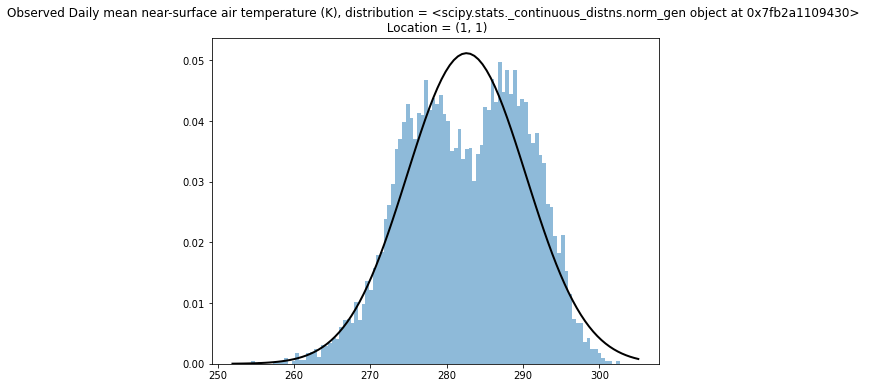

In [13]:
tas_obs_worst_fit = assumptions.plot_worst_fit_aic(variable = 'tas', dataset = tas_obs, 
                                      aic = tas_obs_aic_default, 
                                      data_type = 'Observed', distribution_name = scipy.stats.norm)

Given the plot we see above, and the strong bi-modal distribution of the temperature data, we make the assumption that might be seasonal variation at play here. This can be further investigated by using the following function: it plots the time-series and autocorrelation function of the quantile residuals. It also plot a QQ plot of the normalized quantile residuals to get a picture of the goodness of fit for different quantiles. 

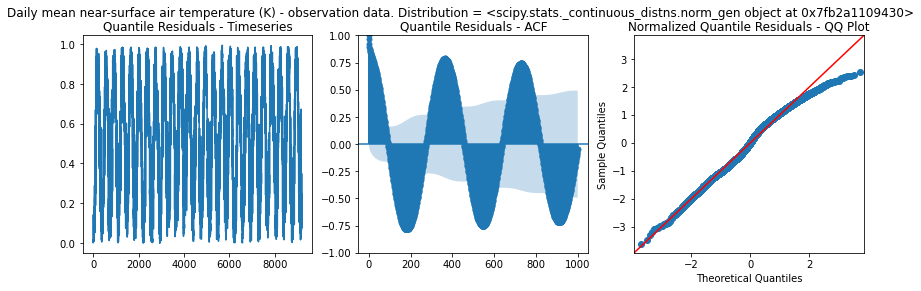

In [14]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(variable = 'tas', dataset = tas_obs[:,0,0], data_type = 'observation data',
                                                      distribution_name = scipy.stats.norm)

**Conclusion:**

Overall the distributions do not seem to fit the temperature data too well. This is due to the bi-modal distribution of temperature. Based on the quantile residuals, we conclude that there is a strong seasonality at play. One option to address this issue would be to build a statistical model that explicitely includes the season as covariate (FIND SOURCE). An alternative approach is taken, for example, in both the QDM as well as the ISIMIP debiasers - using a running mode, a different bias correction is implemented for each day / month (more details in debiaser documentation). This takes care of the seasonality.

## Initializing and applying the debiasers

The following section initializes and applies the debiasers ISIMIP, CDFt and Quantile Delta Mapping (QDM) to the chosen variables. For a more detailed explanaition of the bias correction methods we refer to the documentation, and for some examples on how to customize different debiasers, we refer to the notebook DEBIASER_KNOBS.

**ISIMIP**

In [15]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:29<00:00,  7.32s/it]


In [16]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


In [17]:
tasrange_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasrange_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_validate, **tasrange_dates_validate, verbosity='Error')
tasrange_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_future, **tasrange_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


In [18]:
tasskew_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasskew_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_validate, **tasskew_dates_validate, verbosity='Error')
tasskew_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_future, **tasskew_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]


In [19]:
tasmin_val_debiased_ISIMIP, tasmax_val_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_val_debiased_ISIMIP, tasrange = tasrange_val_debiased_ISIMIP, tasskew = tasskew_val_debiased_ISIMIP)
tasmin_fut_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_fut_debiased_ISIMIP, tasrange = tasrange_fut_debiased_ISIMIP, tasskew = tasskew_fut_debiased_ISIMIP)

**CDFt**

In [20]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_val_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


In [21]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_val_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:00<00:00,  4.01it/s]


**Quantile Delta Mapping**

In [22]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate, verbosity='Error')
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]


In [23]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate, verbosity='Error')
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future, verbosity='Error')

  0%|                                                   | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|███████████████████████████████████████████| 4/4 [00:22<00:00,  5.59s/it]


## Part 2: Evaluation on validation dataset

In [43]:
%%html
<style>
table {float:left}
</style>

### Overview: Statistical Properties and Threshold Metrics

There are essentially two types of analysis that the evaluation module enables you to conduct: one ist an analysis of the statistical properties of the debiased variable - this includes the marginal bias of descriptive statistics such as the mean, or 5th and 95th percentile, as well as the difference in spatial correlation structure. The other is an analysis of threshold metrics. What we mean by the term threshold metrics here, is that specific thresholds are often relevent for impact studies and other applications - for example the number of frost days for crop modelling. Here we can analyse not only the marginal bias, but also the spell length of days of threshold exceedance, or their spatial extent and spatiotemporal cluster size.

The following table gives an overview, which types of analysis are currently available in this release of the package.



|                  | Statistical Properties | Threshold Metrics  |
| ------------     | ---------------------- | -----------------  |
| **Marginal**     | x - marginal bias      | x - marginal bias  |
| **Temporal**     |                        | x - spell length   |
| **Spatial**      | x - RMSE corr matrices | x - spatial extent |
| **Spatioteporal**|                        | x - cluster size   |
| **Multivariate** | x - correlation        |                    |



For each variable, we implemented a number of standard metrics, inspired by the climate extreme indices https://www.climdex.org/learn/indices/

In [31]:
tas_metrics = [warm_days, cold_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]
tasmin_metrics = [tropical_nights, frost_days]
tasmax_metrics = [summer_days, icing_days]

In addition, the user can define new metrics in the following way:

In [32]:
R95p = AccumulativeThresholdMetric(name = '95th percentile \n precipitation', variable = 'pr', 
               threshold_value = [np.quantile(np.ndarray.flatten(pr_obs), 0.95)], threshold_sign = 'higher')

R99p = AccumulativeThresholdMetric(name = '99th percentile \n precipitation', variable = 'pr', 
               threshold_value = [np.quantile(np.ndarray.flatten(pr_obs), 0.99)], threshold_sign = 'higher')

### Marginal Evaluation

We start by investigating the marginal bias of our chosen metrics and descriptive statistics. The user can start with a broader overview plot (see below) and then further investigate that have a particularly large bias, or a particularly large spread across locations, to investigate further.

The plot below shows the distribution of marginal (location-wise) biases across locations. For the mean, this is for example calculated as follows:

$$ Bias_{ij} = 100 * \frac{\bar{tas}_{obs, ij} - \bar{tas}_{cm, ij}}{\bar{tas}_{obs, ij}} $$

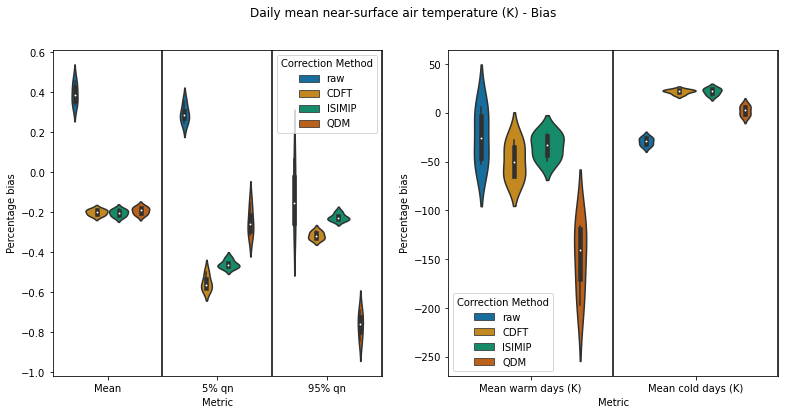

In [33]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,
                                                 obs_data = tas_obs_validate,
                                                 raw = tas_cm_validate, 
                                                 CDFT = tas_val_debiased_CDFT,
                                                 ISIMIP = tas_val_debiased_ISIMIP,
                                                 QDM = tas_val_debiased_QDM)

marginal.plot_marginal_bias(variable = 'tas', bias_array = tas_marginal_bias_data)

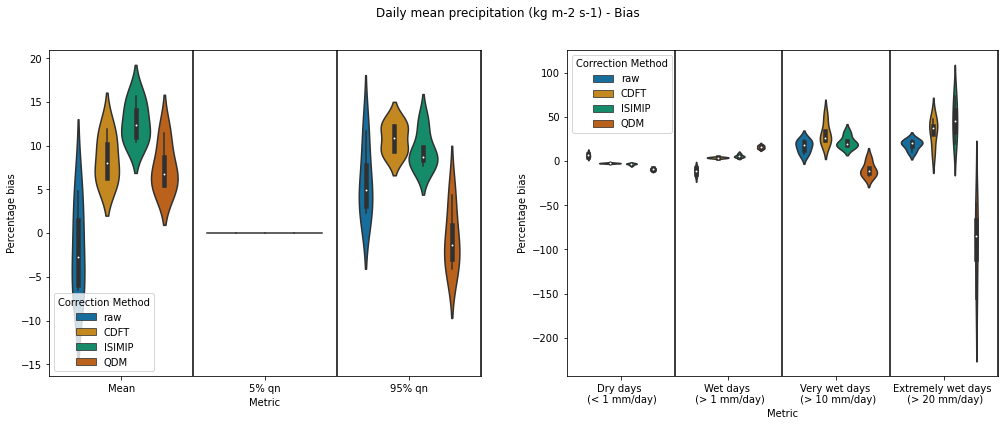

In [34]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics, obs_data = pr_obs_validate,
                                                 raw = pr_cm_validate, 
                                                 CDFT = pr_val_debiased_CDFT,
                                                 ISIMIP = pr_val_debiased_ISIMIP,
                                                 QDM = pr_val_debiased_QDM)
marginal.plot_marginal_bias(variable = 'pr', bias_array = pr_marginal_bias_data)

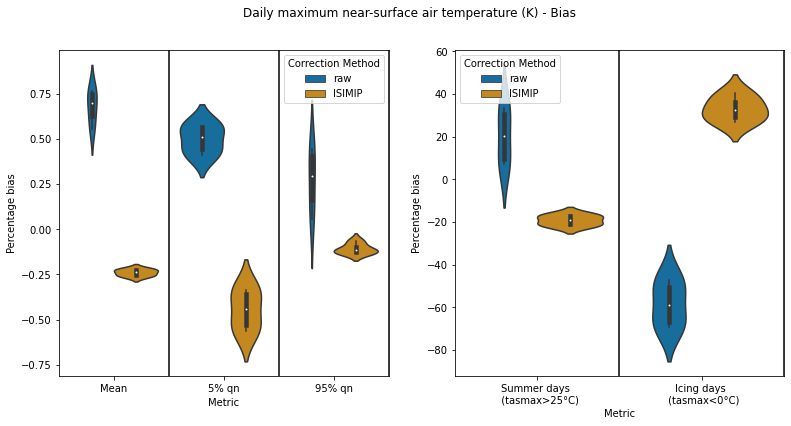

In [35]:
tasmax_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmax_metrics,
                                                 obs_data = tasmax_obs_validate,
                                                 raw = tasmax_cm_validate, 
                                                 ISIMIP = tasmax_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tasmax', bias_array = tasmax_marginal_bias_data)

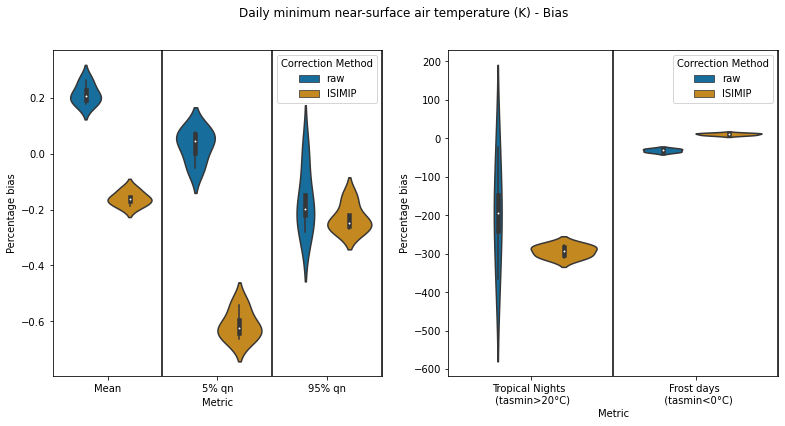

In [36]:
tasmin_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmin_metrics,
                                                 obs_data = tasmin_obs_validate,
                                                 raw = tasmin_cm_validate, 
                                                 ISIMIP = tasmin_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tasmin', bias_array = tasmin_marginal_bias_data)

**Conclusion**: TODO - write this when working with the actual testing data we want to show

**Spatial distribution of marginal biases**

The shape of the distribution in the violinplot above already gives an indication of whether the bias is especially large over certain areas. The following plot explicitely shows the spacial distribution of biases. Particularly high biases in a certain region could point to deficiencies in the underlying climate model (for example, there could be a mountain range over which the climate model performs particularly badly, or other land-atmosphere interactions that are not captured).

The plot below shows exactly the same data as the plot above, just the user chooses one descriptive statistic or threshold metric of which she wants to investigate the spatial distribution of its bias further.

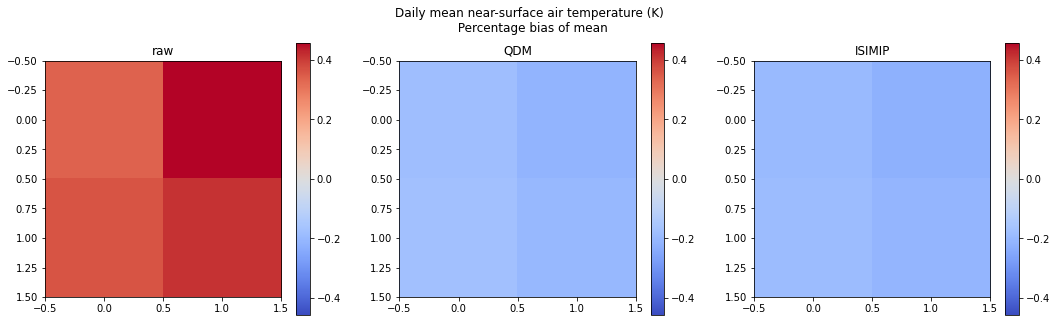

In [45]:
tas_bias_map_mean = spatial.plot_bias_spatial(variable = 'tas', statistic = 'mean', metric = None, obs_data = tas_obs_validate,
                                              raw = tas_cm_validate, QDM = tas_val_debiased_QDM, 
                                              ISIMIP = tas_val_debiased_ISIMIP)

### Spatial, temporal and spatiotemporal properties 

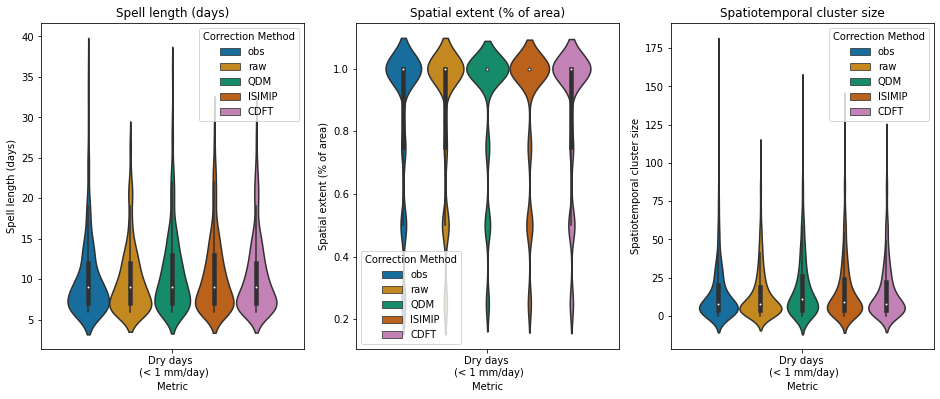

In [46]:
dry_days.plot_clusters_violinplots(minimum_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QDM = pr_val_debiased_QDM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, CDFT = pr_val_debiased_CDFT)

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_51058/812009769.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


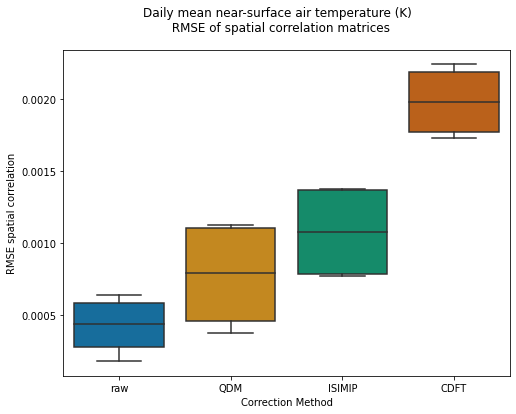

In [47]:
tas_rmsd_spatial = correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                         obs_data = tas_obs_validate, raw = tas_cm_future,
                                                         QDM = tas_val_debiased_QDM, ISIMIP = tas_val_debiased_ISIMIP,
                                                         CDFT = tas_val_debiased_CDFT)
tas_rmsd_spatial_plot = correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

NameError: name 'variable_dictionary' is not defined

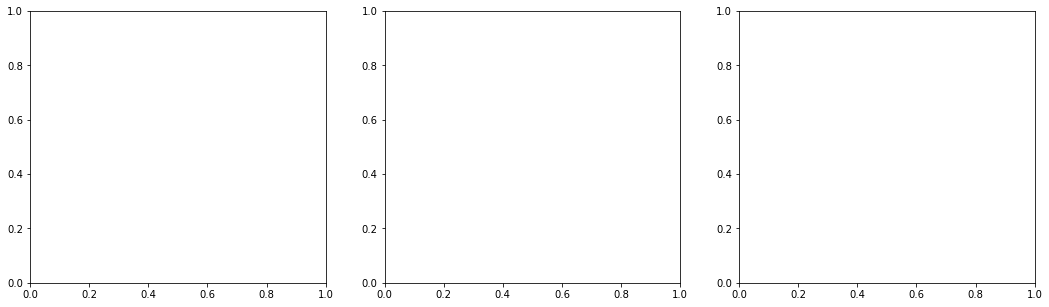

In [48]:
correlation.calculate_multivariate_correlation_locationwise(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

### Multivariate structure

This section is currently in an experimental phase and will be expanded upon in the next releases. Nevertheless, we briefly guide you through the analysis that is currently possible.

NameError: name 'variable_dictionary' is not defined

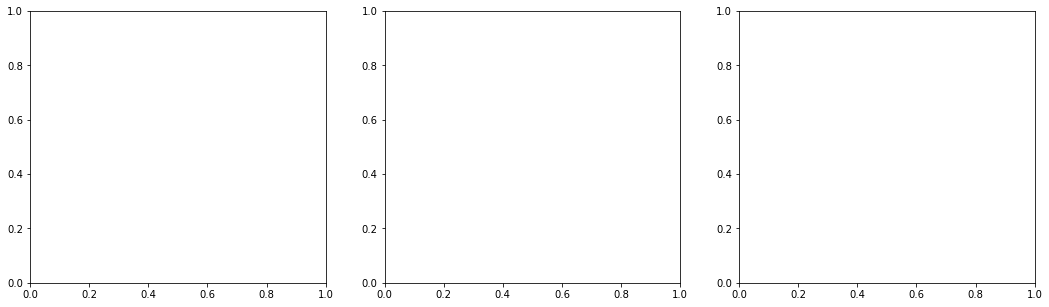

In [49]:
correlation.calculate_multivariate_correlation_locationwise(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

## Part 3: Evaluation of trend preservation


This last section investigates whether the chosen bias correction method modify the trend in the climate model between the validation and the future period. The following steps are conducted in the calculation:
- First, the trend in the chosen statistic (for example the mean) between the validation period and the future period in the *raw* climate model is calculated. 
- Then, the same calculation is performed for the debiased models of interest
- Finally the percentage difference between these two trends is calculated.

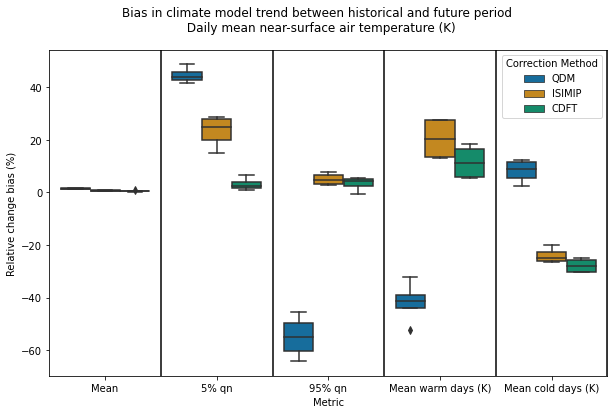

In [37]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', metric_collection = tas_metrics, 
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future, 
                                                  QDM = [tas_val_debiased_QDM, tas_fut_debiased_QDM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  CDFT = [tas_val_debiased_CDFT, tas_fut_debiased_CDFT])

trend.plot_future_trend_bias(variable ='tas', bias_array = tas_trend_bias_data)

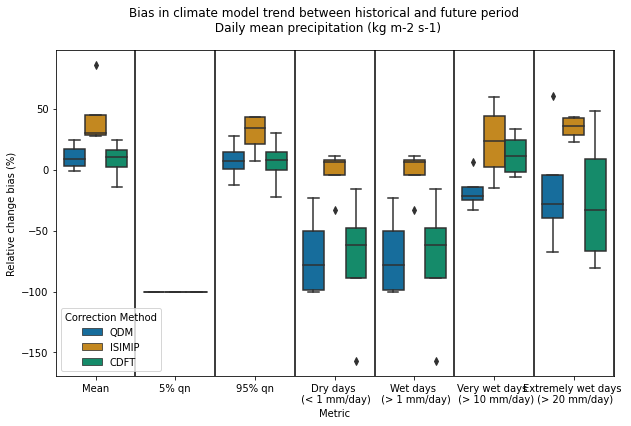

In [38]:
pr_trend_bias_data = trend.calculate_future_trend_bias(variable = 'pr', metric_collection = pr_metrics, 
                                                  raw_validate = pr_cm_validate, raw_future = pr_cm_future, 
                                                  QDM = [pr_val_debiased_QDM, pr_fut_debiased_QDM],
                                                  ISIMIP = [pr_val_debiased_ISIMIP, pr_fut_debiased_ISIMIP],
                                                  CDFT = [pr_val_debiased_CDFT, pr_fut_debiased_CDFT])

trend.plot_future_trend_bias(variable ='pr', bias_array = pr_trend_bias_data)

**Conclusion**: TO-DO when working with final data

## Conclusion

To-do, write when working with actual data that we want to show

## References

AIC: https://www.sciencedirect.com/topics/social-sciences/akaike-information-criterion